In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(font='Noto Sans CJK TC')
mpl.style.use('ggplot')  # must put after sns.set

In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm

/Users/mosky/.local/share/virtualenvs/data-science-with-python-JMAT8Joy/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
fair_df = sm.datasets.fair.load_pandas().data

In [4]:
anova_lm(ols('affairs ~ C(rate_marriage)', fair_df).fit(), typ=2)

,sum_sq,df,F,PR(>F)
C(rate_marriage),1097.674737,4.0,58.569573,1.254257e-48
Residual,29803.482809,6361.0,NaN,NaN


But one-way ANOVA requires [1]:

1. Each group are normally distributed, but not particularly sensitive.
2. The data are homoscedastic, i.e., standard deviations are equal in the groups.
    * If balanced that the number of observations is the same in each group, and then not very sensitive.
    * If unbalanced, the groups with smaller sample sizes also have larger standard deviations, you will get too many false positives.
    * You should try really hard to have equal sample sizes in all of your groups.
    * Or Welch's anova.
    
[1]: http://www.biostathandbook.com/onewayanova.html

Let's verify the assumptions:

In [5]:
sm.stats.stattools.omni_normtest(np.random.randn(100)).pvalue

0.029923911287081228

In [6]:
for i in range(1, 5+1):
    p = sm.stats.stattools.omni_normtest(fair_df.affairs[fair_df.rate_marriage == i]).pvalue
    print(f'i={i}, p={p}')

i=1, p=9.925461688120513e-20
i=2, p=2.3645694691472247e-76
i=3, p=3.0756759331065764e-262
i=4, p=0.0
i=5, p=0.0


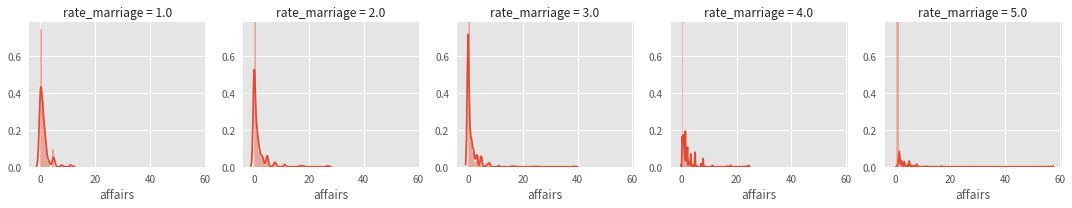

In [7]:
fg = sns.FacetGrid(fair_df, col='rate_marriage')
fg.map(sns.distplot, 'affairs')

OK, not normally distributed.

In [8]:
fair_df.affairs.groupby(fair_df.rate_marriage).describe()

,count,mean,std,min,25%,50%,75%,max
rate_marriage,,,,,,,,
1.0,99.0,1.201671,1.753426,0.0,0.030303,0.727273,1.507691,11.200000
2.0,348.0,1.615745,3.283986,0.0,0.000000,0.521739,1.587290,26.879990
3.0,993.0,1.371281,3.147153,0.0,0.000000,0.212121,1.400000,39.199982
4.0,2242.0,0.674837,1.911211,0.0,0.000000,0.000000,0.484848,24.500000
5.0,2684.0,0.348174,1.699448,0.0,0.000000,0.000000,0.000000,57.599991


Amazing unbalanced groups and inequal groups stds. Fine.

Welch's anova is not available (easily), let's try other solutions.

In [9]:
ols('affairs ~ rate_marriage', fair_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                affairs   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     208.4
Date:                Thu, 23 Nov 2017   Prob (F-statistic):           1.66e-46
Time:                        18:04:01   Log-Likelihood:                -13959.
No. Observations:                6366   AIC:                         2.792e+04
Df Residuals:                    6364   BIC:                         2.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.3825      0.119     19.969      0.000       2.149       2.616
rate_marriage    -0.4081      0.028    -14.436      0.000      -0.464      -0.353
==============================================================================
Omnibus:                     9443.528   Durbin-Watson:                   1.606
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5215639.758
Skew:                           8.930   Prob(JB):                         0.00
Kurtosis:                     142.083   Cond. No.                         19.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

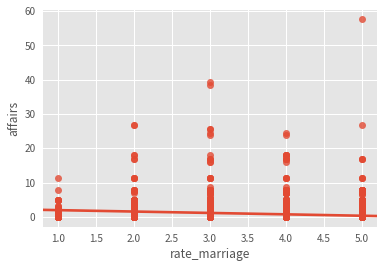

In [10]:
sns.regplot(data=fair_df, x='rate_marriage', y='affairs')

In [11]:
np.corrcoef(fair_df.rate_marriage, fair_df.affairs)

array([[ 1.        , -0.17806816],
       [-0.17806816,  1.        ]])

Looks good. Can it be better?

In [12]:
# c: cleaned
d = fair_df
display(d.shape)

m = d.mean()
s = d.std()
d = d[(d > m-s*3) & (d < m+s*3)].dropna()
display(d.shape)

cfair_df = d

(6366, 9)

(6149, 9)

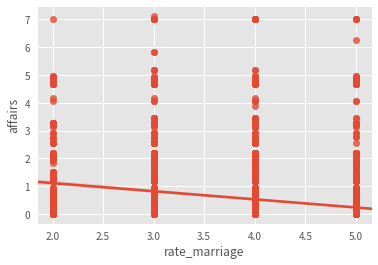

In [13]:
sns.regplot(data=cfair_df, x='rate_marriage', y='affairs')

In [14]:
np.corrcoef(cfair_df.rate_marriage, cfair_df.affairs)

array([[ 1.        , -0.23632434],
       [-0.23632434,  1.        ]])

OK, so the other ways also prove the relationship. Great!